# Prédiction du risque de faillite d'une entreprise

EL HACHMI Séhame 



<br>

### Nettoyage des données

###### On commence par importer les packages.

In [220]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import math

###### On importe la table avec les bons formats et on supprime les valeurs manquantes et les doublons s'il y en a. 

In [294]:
table = pd.read_csv('./big_startup_secsees_dataset.csv', delimiter = ",", 
                    parse_dates = ["founded_at","first_funding_at","last_funding_at"])

table["founded_at"] = pd.to_datetime(table["founded_at"], errors='coerce')
table["first_funding_at"] = pd.to_datetime(table["first_funding_at"], errors='coerce')
table['category_list'] = table['category_list'].str.replace("|", "_") \
                                                .str.replace(" ", "_") \
                                                .str.replace("+", "_") \
                                                .str.replace("-", "_")

table = table.dropna()
table = table.drop_duplicates()
table.info()
table.head()

<class 'pandas.core.frame.DataFrame'>
Index: 42978 entries, 1 to 66366
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   permalink          42978 non-null  object        
 1   name               42978 non-null  object        
 2   homepage_url       42978 non-null  object        
 3   category_list      42978 non-null  object        
 4   funding_total_usd  42978 non-null  object        
 5   status             42978 non-null  object        
 6   country_code       42978 non-null  object        
 7   state_code         42978 non-null  object        
 8   region             42978 non-null  object        
 9   city               42978 non-null  object        
 10  funding_rounds     42978 non-null  int64         
 11  founded_at         42978 non-null  datetime64[ns]
 12  first_funding_at   42978 non-null  datetime64[ns]
 13  last_funding_at    42978 non-null  datetime64[ns]
dtypes: datetime

,permalink,name,homepage_url,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at
1,/organization/-qounter,:Qounter,http://www.qounter.com,Application_Platforms_Real_Time_Social_Network...,700000,operating,USA,DE,DE - Other,Delaware City,2,2014-09-04,2014-03-01,2014-10-14
3,/organization/0-6-com,0-6.com,http://www.0-6.com,Curated_Web,2000000,operating,CHN,22,Beijing,Beijing,1,2007-01-01,2008-03-19,2008-03-19
4,/organization/004-technologies,004 Technologies,http://004gmbh.de/en/004-interact,Software,-,operating,USA,IL,"Springfield, Illinois",Champaign,1,2010-01-01,2014-07-24,2014-07-24
6,/organization/0ndine-biomedical-inc,Ondine Biomedical Inc.,http://ondinebio.com,Biotechnology,762851,operating,CAN,BC,Vancouver,Vancouver,2,1997-01-01,2009-09-11,2009-12-21
7,/organization/0xdata,H2O.ai,http://h2o.ai/,Analytics,33600000,operating,USA,CA,SF Bay Area,Mountain View,4,2011-01-01,2013-01-03,2015-11-09


###### On enlève les valeurs manquantes qui prennent la forme de "-" afin de mettre la variable fonds totaux en numérique.

In [295]:
table['funding_total_usd'] = table['funding_total_usd'].replace('-', np.nan)
table['funding_total_usd'] = pd.to_numeric(table['funding_total_usd'], errors = 'coerce')
table = table.dropna(subset = ['funding_total_usd'])
print(table.dtypes)

permalink                    object
name                         object
homepage_url                 object
category_list                object
funding_total_usd           float64
status                       object
country_code                 object
state_code                   object
region                       object
city                         object
funding_rounds                int64
founded_at           datetime64[ns]
first_funding_at     datetime64[ns]
last_funding_at      datetime64[ns]
dtype: object


###### On adapte les variables au modèle que l'on va estimer.
- Hypothèse : L'entreprise qui échoue a échoué juste après son dernier financement.

In [296]:
status_garde = ["closed", "operating"]
table = table[table['status'].isin(status_garde)]

Conditions = [
 (table['status'] == "closed" ),
 (table['status'] == "operating")
]
Categories = [1,0]
table['failure'] = np.select(Conditions, Categories)

annee_actuelle = 2025 
Conditions1 = [
 (table['failure'] ==1 ),
 (table['failure'] !=1)
]
Categories1 = [table["last_funding_at"].dt.year - table['founded_at'].dt.year, annee_actuelle - table['founded_at'].dt.year
             ]
table['age'] = np.select(Conditions1, Categories1)
table = table[table['age'] >= 0]

table = table.dropna()

table.sample(5)

,permalink,name,homepage_url,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,failure,age
20975,/organization/flowplay,FlowPlay,http://www.flowplay.com,Gambling_Games_Messaging_MMO_Games_Virtual_Worlds,5039999.0,operating,USA,WA,Seattle,Seattle,4,2006-12-01,2007-05-01,2010-08-20,0,19
58600,/organization/toplog,TopLog,http://toplog.io/,Software,377358.0,operating,CAN,NS,Halifax,Halifax,1,2013-01-01,2013-12-12,2013-12-12,0,12
53192,/organization/solfocus,SolFocus,http://www.solfocus.com,Clean_Technology_Solar,211403000.0,closed,USA,CA,SF Bay Area,San Jose,8,2005-11-01,2006-03-01,2012-04-01,1,7
35154,/organization/meez,Meez,http://meez.com,3D_Entertainment_Games_Messaging,10200000.0,operating,USA,CA,SF Bay Area,San Francisco,3,2009-03-20,2005-01-01,2007-09-01,0,16
32837,/organization/livevox,LiveVox,http://www.livevox.com,Web_Hosting,12100000.0,operating,USA,CA,SF Bay Area,San Francisco,2,1999-10-01,2007-06-19,2008-01-28,0,26


###### On regarde si on devrait mettre des variables en logarithmes ou peut être les standardiser.

In [297]:
table['log_funding_total_usd'] = np.log1p(table['funding_total_usd'])
table['log_age'] = np.log1p(table['age'])
table['log_funding_rounds'] = np.log1p(table['funding_rounds'])

variables =['age', 'funding_total_usd', 'funding_rounds']
variables_log = ['log_age', 'log_funding_total_usd', 'log_funding_rounds']

print(table[variables].describe())
print(table[variables_log].describe())

                age  funding_total_usd  funding_rounds
count  31994.000000       3.199400e+04    31994.000000
mean      15.610771       1.455362e+07        2.011658
std       10.171449       8.037759e+07        1.535101
min        0.000000       1.000000e+00        1.000000
25%       12.000000       3.000000e+05        1.000000
50%       14.000000       1.600000e+06        1.000000
75%       18.000000       8.100000e+06        2.000000
max      259.000000       8.207450e+09       19.000000
            log_age  log_funding_total_usd  log_funding_rounds
count  31994.000000           31994.000000        31994.000000
mean       2.669048              14.230279            1.011570
std        0.612660               2.327216            0.396575
min        0.000000               0.693147            0.693147
25%        2.564949              12.611541            0.693147
50%        2.708050              14.285515            0.693147
75%        2.944439              15.907375            1.098612
m

In [225]:
var = ["age","log_funding_total_usd", "funding_rounds"]

###### On enlève les valeurs extrêmes.

In [298]:
for v in var :
    Q1 = table[v].quantile(0.25)
    Q3 = table[v].quantile(0.75)
    ecart = Q3 - Q1
    borne_inf = Q1 - 1.5 * ecart
    borne_supp = Q3 + 1.5 * ecart

    table = table[(table[v] >= borne_inf) & (table[v] <= borne_supp)]


table[var1].describe()

,age,funding_rounds,funding_total_usd
count,28239.000000,28239.000000,2.823900e+04
mean,14.938773,1.922164,1.138863e+07
std,4.155706,1.221907,3.865616e+07
min,3.000000,1.000000,2.250000e+03
25%,12.000000,1.000000,3.000000e+05
50%,14.000000,1.000000,1.500000e+06
75%,17.000000,2.000000,7.349070e+06
max,27.000000,6.000000,1.085000e+09


###### Maintenant, on sous échantillonne.

In [299]:
ocde = ['AUS', 'AUT', 'BEL', 'CAN', 'CHL', 'COL', 'CZE', 'DNK', 'EST', 'FIN', 'FRA', 'DEU', 'GRC', 'HUN', 'ISL', 'IRL'
                  , 'ITA', 'JPN', 'KOR', 'LVA', 'LTU', 'LUX', 'MEX', 'NLD', 'NZL', 'NOR', 'POL', 'PRT', 'SVK', 'SVN', 
        'ESP', 'SWE','CHE', 'TUR', 'GBR', 'USA']
tech = ["Networking","Networking_Web_Hosting","Telecommunications","Consumer_Electronics","Nanotechnology",
                "Apps","Technology","Biotechnology_Health_Care","Information_Technology","Finance_FinTech",
                "EdTech_Education","Entertainment_Games","Web_Hosting","Social_Media","Analytics","Security",
                "Semiconductors","Games","Enterprise_Software","Hardware___Software","Clean_Technology","Curated_Web",
                "E_Commerce","Mobile","Biotechnology","Software"]


table = table[table['country_code'].isin(ocde) & table['category_list'].isin(tech)]
table.head()

,permalink,name,homepage_url,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,failure,age,log_funding_total_usd,log_age,log_funding_rounds
7,/organization/0xdata,H2O.ai,http://h2o.ai/,Analytics,33600000.0,operating,USA,CA,SF Bay Area,Mountain View,4,2011-01-01,2013-01-03,2015-11-09,0,14,17.330037,2.708050,1.609438
8,/organization/1,One Inc.,http://whatis1.com,Mobile,1150050.0,operating,USA,CA,SF Bay Area,San Francisco,3,2011-08-01,2011-07-20,2014-02-05,0,14,13.955317,2.708050,1.386294
9,/organization/1-2-3-listo,"1,2,3 Listo",http://www.123listo.com,E_Commerce,40000.0,operating,CHL,12,Santiago,Las Condes,1,2012-01-01,2013-02-18,2013-02-18,0,13,10.596660,2.639057,0.693147
17,/organization/10-20-media,10-20 Media,http://www.10-20media.com,E_Commerce,2050000.0,operating,USA,MD,Baltimore,Woodbine,4,2001-01-01,2009-06-18,2011-12-28,0,24,14.533351,3.218876,1.609438
41,/organization/10x-technologies,10X Technologies,http://10xtechnologies.com,Biotechnology,3550000.0,operating,USA,CA,SF Bay Area,Oakland,2,2012-01-01,2012-11-07,2015-01-12,0,13,15.082458,2.639057,1.098612


In [300]:
table.groupby(['status'])['status'].count()

status
closed        385
operating    6572
Name: status, dtype: int64

###### On divise l'échantillon en deux

In [302]:
X= pd.concat([table[var], 
                     pd.get_dummies(table[['country_code', 'category_list']], drop_first=True)], axis=1)

y = table['failure']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=12)
X_train, X_test = X_train.align(X_test, join='inner', axis=1)

print(X_train.describe())
print(X_test.describe())

               age  log_funding_total_usd  funding_rounds
count  4869.000000            4869.000000     4869.000000
mean     16.422058              14.658503        1.973300
std       4.821158               2.132652        1.286786
min       3.000000               7.824446        1.000000
25%      13.000000              13.235258        1.000000
50%      16.000000              14.808763        1.000000
75%      20.000000              16.204273        3.000000
max      27.000000              20.426207        6.000000
               age  log_funding_total_usd  funding_rounds
count  2088.000000            2088.000000     2088.000000
mean     16.356322              14.621969        1.959770
std       4.788727               2.151756        1.264422
min       3.000000               7.719130        1.000000
25%      13.000000              13.142167        1.000000
50%      16.000000              14.678163        1.000000
75%      19.000000              16.166886        3.000000
max      27.00

###### Et on centre et réduit les données. 

In [304]:
moy_X_train= X_train[var].mean()
std_X_train= X_train[var].std()

X_train[var] = (X_train[var] - moy_X_train) / std_X_train
X_test[var]= (X_test[var] - moy_X_train) / std_X_train
print("Statistiques descriptives de l'échantillon d'entrainement : \n",X_train.describe())
print("\nStatistiques descriptives de l'échantillon test : \n",X_test.describe())

Statistiques descriptives de l'échantillon d'entrainement : 
                 age  log_funding_total_usd  funding_rounds
count  4.869000e+03           4.869000e+03     4869.000000
mean   2.043048e-17          -1.313388e-17        0.000000
std    1.000000e+00           1.000000e+00        1.000000
min   -2.783990e+00          -3.204487e+00       -0.756381
25%   -7.098000e-01          -6.673592e-01       -0.756381
50%   -8.754285e-02           7.045663e-02       -0.756381
75%    7.421333e-01           7.248112e-01        0.797879
max    2.194067e+00           2.704474e+00        3.129268

Statistiques descriptives de l'échantillon test : 
                age  log_funding_total_usd  funding_rounds
count  2088.000000            2088.000000     2088.000000
mean     -0.013635              -0.017131       -0.010515
std       0.993273               1.008958        0.982620
min      -2.783990              -3.253870       -0.756381
25%      -0.709800              -0.711009       -0.756381
50%   

### Statistiques descriptives 

#### Tableau et histogrammes des statistiques descriptives 

In [305]:
table["funding_total_usd1"]= table["funding_total_usd"]/1000000

stat = table[["age","funding_total_usd","funding_rounds"]].describe()

stat_latex= stat.to_latex(index=True)

with open("stat.tex", "w") as f:
    f.write(stat_latex)
    
stat

,age,funding_total_usd,funding_rounds
count,6957.000000,6.957000e+03,6957.00000
mean,16.402329,1.326675e+07,1.96924
std,4.811198,3.454982e+07,1.28004
min,3.000000,2.250000e+03,1.00000
25%,13.000000,5.432700e+05,1.00000
50%,16.000000,2.577585e+06,1.00000
75%,20.000000,1.085000e+07,3.00000
max,27.000000,7.430000e+08,6.00000


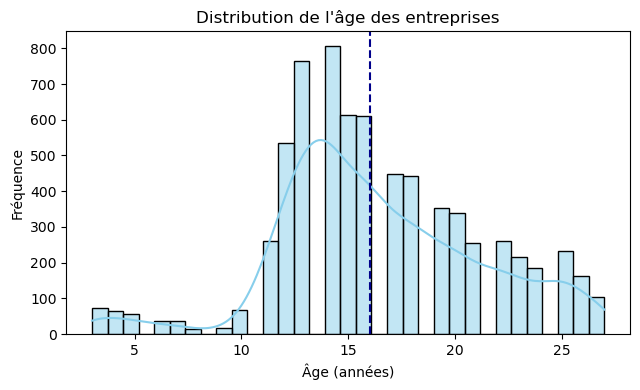

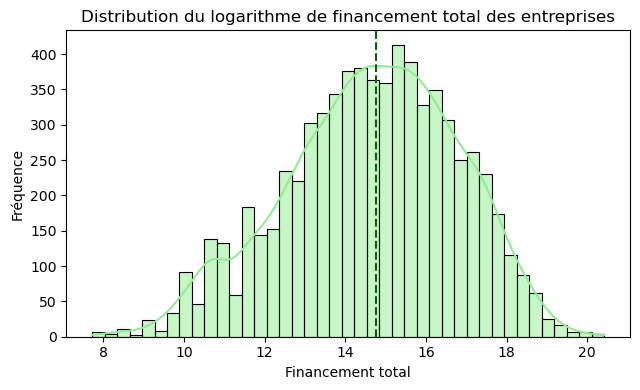

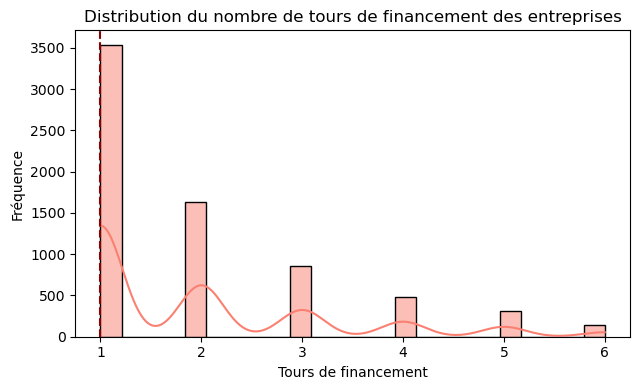

In [306]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

median_age = table['age'].median()
median_funding_total_usd = table['log_funding_total_usd'].median()
median_funding_rounds = table['funding_rounds'].median()


plt.figure(figsize=(6.5,4))

sns.histplot(table['age'], kde=True, color="skyblue")
plt.axvline(median_age, color='darkblue', linestyle='--', label=f'Médiane = {median_age:.2f}') 
plt.title('Distribution de l\'âge des entreprises')
plt.xlabel('Âge (années)')
plt.ylabel('Fréquence')

plt.tight_layout()
plt.savefig('histogramme_age.png')

plt.show()
plt.close()

plt.figure(figsize=(6.5,4))

sns.histplot(table['log_funding_total_usd'], kde=True, color="lightgreen")
plt.axvline(median_funding_total_usd, color='darkgreen', linestyle='--', label=f'Médiane = {median_age:.2f}') 
plt.title("Distribution du logarithme de financement total des entreprises")
plt.xlabel("Financement total")
plt.ylabel('Fréquence')

plt.tight_layout()
plt.savefig('histogramme_total.png')

plt.show()
plt.close()

plt.figure(figsize=(6.5,4))

sns.histplot(table['funding_rounds'], kde=True, color="salmon")
plt.axvline(median_funding_rounds, color='darkred', linestyle='--', label=f'Médiane = {median_age:.2f}') 
plt.title('Distribution du nombre de tours de financement des entreprises')
plt.xlabel('Tours de financement')
plt.ylabel('Fréquence')

plt.tight_layout()
plt.savefig('histogramme_tours.png')

plt.show()
plt.close()

#### Comparaison entre les entreprises fermées et celles en activités

In [307]:
table_copy = table.copy()

table_copy['status'] = table_copy['status'].replace({
    'operating': 'En activité',
    'closed': 'Fermée'
})

comparaison_age =table_copy.groupby('status')[['age']].agg(['mean', 'median', 'std','min','max'])

comparaison_age_latex= comparaison_age.to_latex(index=True)
with open("comparaison_age.tex", "w") as f:
    f.write(comparaison_age_latex)
    

comparaison_funding_total_usd =table_copy.groupby('status')[['funding_total_usd1']].agg(['mean', 'median', 'std','min','max'])

comparaison_funding_total_usd_latex= comparaison_funding_total_usd.to_latex(index=True)
with open("comparaison_funding_total_usd.tex", "w") as f:
    f.write(comparaison_funding_total_usd_latex)
    


comparaison_funding_rounds =table_copy.groupby('status')[['funding_rounds']].agg(['mean', 'median', 'std','min','max'])

comparaison_funding_rounds_latex= comparaison_funding_rounds.to_latex(index=True)
with open("comparaison_funding_rounds.tex", "w") as f:
    f.write(comparaison_funding_rounds_latex)
    

    
print(comparaison_age)
print(comparaison_funding_total_usd)
print(comparaison_funding_rounds)

                   age                         
                  mean median       std min max
status                                         
En activité  16.938071   16.0  4.227653  10  27
Fermée        7.257143    5.0  4.970104   3  27
            funding_total_usd1                                       
                          mean median        std      min         max
status                                                               
En activité          13.027462   2.45  34.795048  0.00225  743.000000
Fermée               17.351372   7.24  29.800933  0.00275  365.872959
            funding_rounds                         
                      mean median       std min max
status                                             
En activité       1.964090    1.0  1.278906   1   6
Fermée            2.057143    2.0  1.297777   1   6


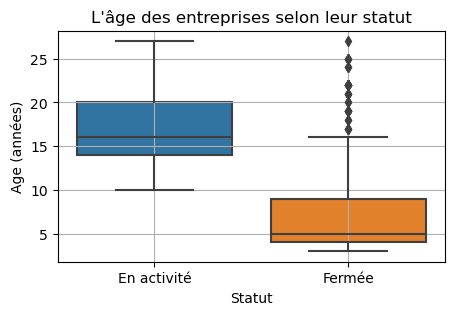

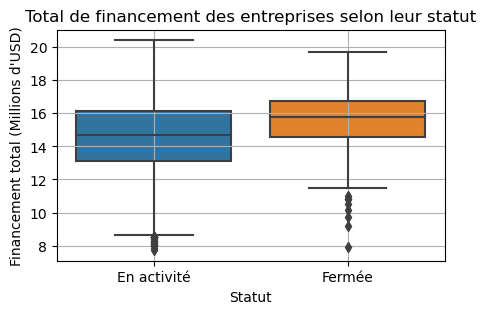

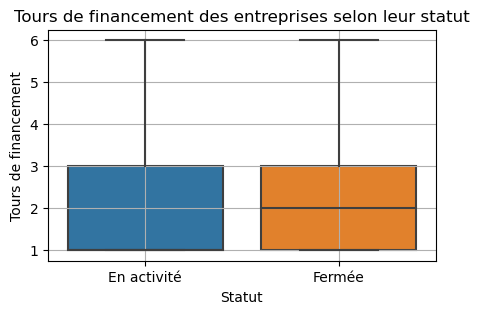

In [308]:
plt.figure(figsize=(5,3))
sns.boxplot(x='status', y='age', data=table_copy)
plt.title("L'âge des entreprises selon leur statut")
plt.xlabel("Statut")
plt.ylabel("Age (années)")
plt.grid(True)
plt.savefig('gcomparaison_age.png',bbox_inches='tight')

plt.show()
plt.close()

plt.figure(figsize=(5,3))
sns.boxplot(x='status', y='log_funding_total_usd', data=table_copy)
plt.title("Total de financement des entreprises selon leur statut")
plt.xlabel("Statut")
plt.ylabel("Financement total (Millions d'USD)")
plt.grid(True)
plt.savefig('gcomparaison_total.png',bbox_inches='tight')

plt.show()
plt.close()

plt.figure(figsize=(5,3))
sns.boxplot(x='status', y='funding_rounds', data=table_copy)
plt.title("Tours de financement des entreprises selon leur statut")
plt.xlabel("Statut")
plt.ylabel("Tours de financement")
plt.grid(True)
plt.savefig('gcomparaison_tours.png',bbox_inches='tight')


plt.show()
plt.close()

#### Pays pour lesquels il y a plus ou moins de faillite

In [310]:
failure_sum = table.groupby(['country_code'])['failure'].sum()
failure_count = table.groupby(['country_code'])['failure'].count()
failure_percentage =((failure_sum / failure_count) * 100).round(2)


failure_df = pd.DataFrame({
    'Pourcentage de faillites': failure_percentage,
    'Nombre de faillites': failure_sum,
    "Nombre d'apparitions": failure_count

})

failure_df.index.name = 'Pays'
noms = {
    'AUS': "Australie",
    'CAN': 'Canada',
    'CHL': 'Chili',
    'DEU': 'Allemagne',
    'ESP': "Espagne",
    'FRA': 'France',
    'GBR': 'Royaume-Uni',
    'KOR': 'Corée du Sud',
    'SWE': 'Suède',
    'USA': 'États-Unis'
}


failure_df.index = failure_df.index.map(noms)
failure_df=failure_df[failure_df["Nombre d'apparitions"]> 49]


failure_df_latex= failure_df.to_latex(index=True)

with open("failure_pays.tex", "w") as f:
    f.write(failure_df_latex)
    
failure_df

,Pourcentage de faillites,Nombre de faillites,Nombre d'apparitions
Pays,,,
Australie,3.92,2,51
Canada,8.11,21,259
Chili,0.00,0,58
Allemagne,9.09,9,99
Espagne,9.80,5,51
France,6.49,12,185
Royaume-Uni,4.30,18,419
Corée du Sud,0.00,0,86
Suède,6.45,4,62


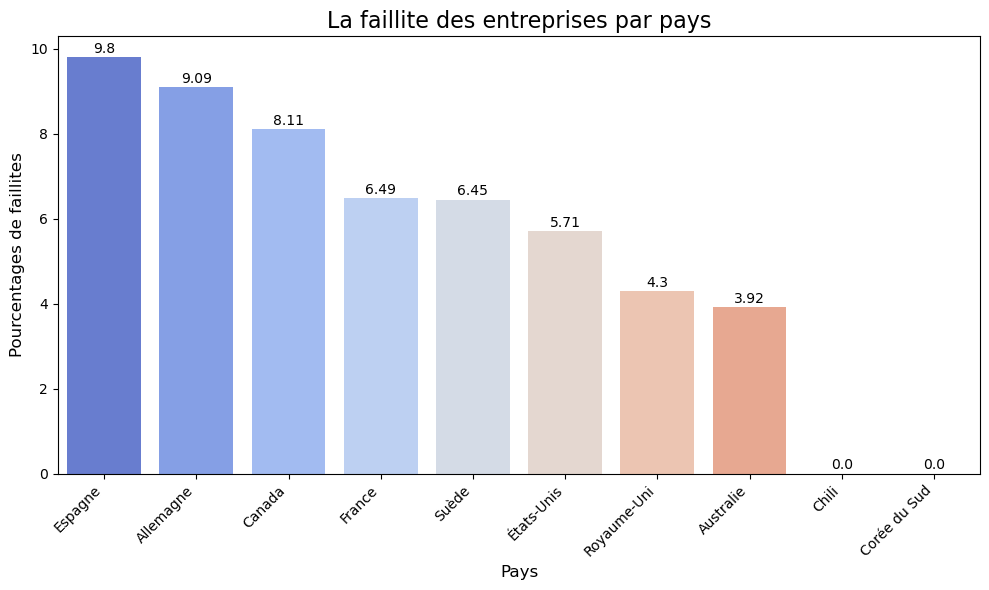

In [309]:
failure_df = failure_df.sort_values(by='Pourcentage de faillites', ascending=False)

plt.figure(figsize=(10, 6))

sns.barplot(x=failure_df.index, y='Pourcentage de faillites', data=failure_df, palette='coolwarm')

plt.title('La faillite des entreprises par pays', fontsize=16)
plt.xlabel('Pays', fontsize=12)
plt.ylabel('Pourcentages de faillites', fontsize=12)


for i, value in enumerate(failure_df['Pourcentage de faillites']):
    plt.text(i, failure_df['Pourcentage de faillites'][i] + 0.1, str(value), ha='center', fontsize=10, color='black')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('faillite_pays.png') 

plt.show()
plt.close()

#### Secteurs pour lesquels il y a plus ou moins de faillite

In [311]:
failure_sum1 =table.groupby(['category_list'])['failure'].sum()
failure_count1 = table.groupby(['category_list'])['failure'].count()
failure_percentage1 =((failure_sum1 / failure_count1) * 100).round(2)


failure_df1 = pd.DataFrame({
    'Pourcentage de faillites': failure_percentage1,
    'Nombre de faillites': failure_sum1,
    "Nombre d'apparitions": failure_count1
    
})

failure_df1.index.name = 'Secteurs'
translation = {
    'Analytics': 'Analyse',
    'Biotechnology': 'Biotechnologie',
    'Clean_Technology': 'Technologie propre',
    'Curated_Web': 'Web sélectionné',
    'E_Commerce': 'E-commerce',
    'EdTech_Education': 'Éducation technologique',
    'Enterprise_Software': 'Logiciel d\'entreprise',
    'Finance_FinTech' : "Finance / FinTech",
    'Games': 'Jeux',
    'Hardware___Software': 'Matériel et logiciel',
    'Information_Technology': 'Technologie de l\'information',
    'Mobile': 'Mobile',
    'Security': 'Sécurité',
    'Semiconductors': 'Semi-conducteurs',
    'Social_Media': 'Médias sociaux',
    'Software': 'Logiciel',
    'Technology': 'Technologie',
    'Web_Hosting': 'Hébergement web'
}

failure_df1.index = failure_df1.index.map(translation)


failure_df1=failure_df1[failure_df1["Nombre d'apparitions"]> 49]



failure_df1_latex= failure_df1.to_latex(index=True)

with open("failure_secteur.tex", "w") as f:
    f.write(failure_df1_latex)
    
failure_df1

,Pourcentage de faillites,Nombre de faillites,Nombre d'apparitions
Secteurs,,,
Analyse,2.01,3,149
Biotechnologie,5.57,80,1435
Technologie propre,8.06,34,422
Web sélectionné,4.65,16,344
E-commerce,3.08,13,422
Éducation technologique,2.86,2,70
Logiciel d'entreprise,3.61,12,332
Finance / FinTech,9.84,6,61
Jeux,6.10,18,295


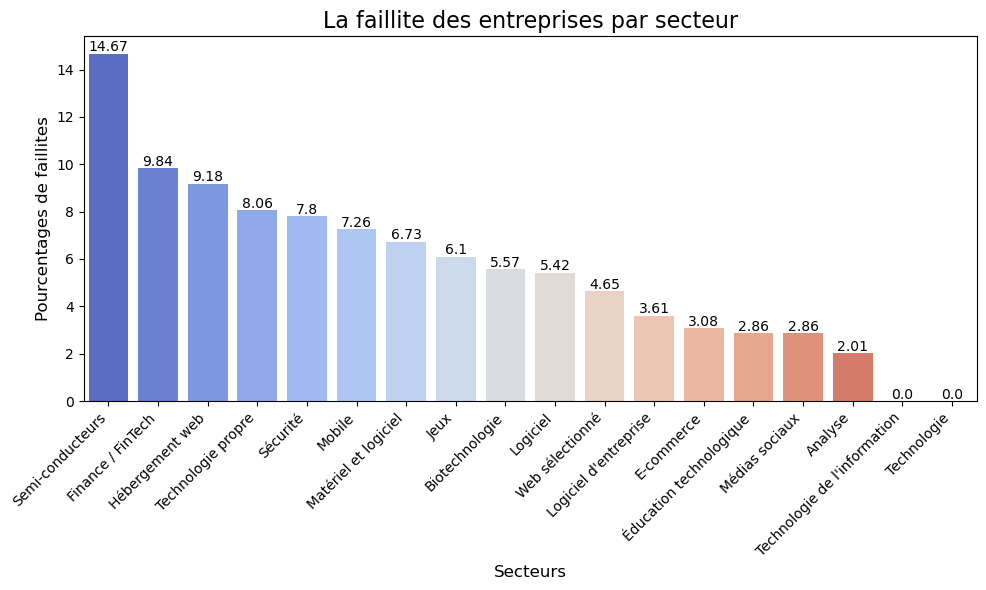

In [312]:
failure_df1 = failure_df1.sort_values(by='Pourcentage de faillites', ascending=False)

plt.figure(figsize=(10, 6))

sns.barplot(x=failure_df1.index, y='Pourcentage de faillites', data=failure_df1, palette='coolwarm')

plt.title('La faillite des entreprises par secteur', fontsize=16)
plt.xlabel('Secteurs', fontsize=12)
plt.ylabel('Pourcentages de faillites', fontsize=12)



for i, value in enumerate(failure_df1['Pourcentage de faillites']):
    plt.text(i, failure_df1['Pourcentage de faillites'][i] + 0.1, str(value), ha='center', fontsize=10, color='black')
    
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('faillite_secteur.png') 

plt.show()
plt.close()

#### Matrice de corrélation

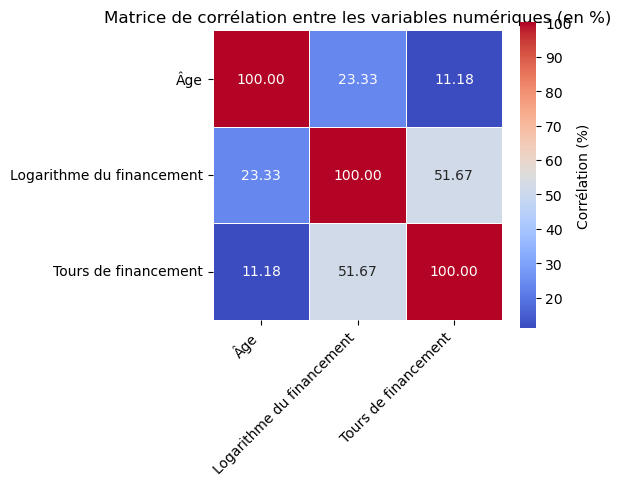

In [313]:
correlation = table[var].corr()
noms = {
    'age': "Âge",
    'log_funding_total_usd': "Logarithme du financement",
    'funding_rounds': "Tours de financement"
}

correlation0 = correlation.rename(index=noms, columns=noms)
correlation1 = correlation0 * 100

plt.figure(figsize=(6, 5))
sns.heatmap(
    correlation1,
    annot=True,
    fmt=".2f", 
    cmap="coolwarm",
    square=True,
    linewidths=0.5,
    cbar_kws={"label": "Corrélation (%)"}
)

plt.title("Matrice de corrélation entre les variables numériques (en %)")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('correlation.png',bbox_inches='tight')

plt.show()
plt.close()

### Régression avec statsmodels

###### On importe les packages.

In [240]:
import statsmodels.api as sm
import joblib

###### On convertit les booléens en int.

In [315]:
X_train = X_train.astype({col: 'int' for col in X_train.select_dtypes('bool').columns})
X_test = X_test.astype({col: 'int' for col in X_test.select_dtypes('bool').columns})

###### On crée et entraine le modèle.

In [316]:
X_train_sm = sm.add_constant(X_train)
logit_sm = sm.Logit(y_train, X_train_sm)
result = logit_sm.fit_regularized(penalizer='l1', alpha=0.1)

with open('resume_logit.tex', 'w') as f:
    f.write(result.summary().as_latex())

print(result.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.07285565164325844
            Iterations: 636
            Function evaluations: 636
            Gradient evaluations: 636


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 15 out of 63 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


                           Logit Regression Results                           
Dep. Variable:                failure   No. Observations:                 4869
Model:                          Logit   Df Residuals:                     4806
Method:                           MLE   Df Model:                           62
Date:                Wed, 07 May 2025   Pseudo R-squ.:                  0.6647
Time:                        13:15:52   Log-Likelihood:                -348.90
converged:                       True   LL-Null:                       -1040.4
Covariance Type:            nonrobust   LLR p-value:                2.877e-248
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                                      -6.2444      1.466     -4.260      0.000      -9.117      -3.372
age                                        -

###### On calcule les effets marginaux. 

In [317]:
em = result.get_margeff()

em_summary = em.summary()
latex_em= em_summary.as_latex()

with open('em_logistique.tex', 'w') as f:
    f.write(latex_em)
    
print(em.summary())

        Logit Marginal Effects       
Dep. Variable:                failure
Method:                          dydx
At:                           overall
                                             dy/dx    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
age                                        -0.0613      0.004    -17.436      0.000      -0.068      -0.054
log_funding_total_usd                       0.0132      0.003      5.038      0.000       0.008       0.018
funding_rounds                              0.0022      0.002      0.960      0.337      -0.002       0.007
country_code_AUT                           -0.0073      0.062     -0.116      0.907      -0.129       0.115
country_code_BEL                            0.0220      0.030      0.722      0.470      -0.038       0.082
country_code_CAN                            0.0170      0.024      0.717      0.473      -0.

###### On prédit.

In [318]:
predictions_proba0 = result.predict(sm.add_constant(X_test))

print("Prédictions des probabilités:\n",predictions_proba0[:10])

Prédictions des probabilités:
 40274    0.000169
43057    0.068952
34307    0.000022
50908    0.019532
20731    0.001011
6217     0.020654
15140    0.007983
56776    0.000009
13787    0.000006
49386    0.007137
dtype: float64


### Régression avec sklearn 

###### On importe les packages.

In [319]:
from sklearn.linear_model import LogisticRegression
import joblib

###### On convertit les booléens en int. 

In [320]:
X_train = X_train.astype({col: 'int' for col in X_train.select_dtypes('bool').columns})
X_test = X_test.astype({col: 'int' for col in X_test.select_dtypes('bool').columns})

###### On crée et entraine le modèle.

In [321]:
resultat1 = LogisticRegression(class_weight='balanced', penalty='l1', solver='liblinear', random_state=42)
resultat1.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', penalty='l1', random_state=42,
                   solver='liblinear')

###### On prédit.

In [322]:
predictions = resultat1.predict(X_test)
predictions_proba = resultat1.predict_proba(X_test)[:, 1]

print("Prédiction : ",predictions[:100])
print("\nPrédiction des probabilités : ",predictions_proba[:10])

Prédiction :  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Prédiction des probabilités :  [0.01550319 0.31203707 0.00526508 0.33650699 0.02013067 0.45140715
 0.21605724 0.0046415  0.00232992 0.13377971]


In [323]:
joblib.dump(resultat1, 'logistic_regression_model1.pkl')

['logistic_regression_model1.pkl']

#### Evaluation du modèle

###### Matrice de confusion 

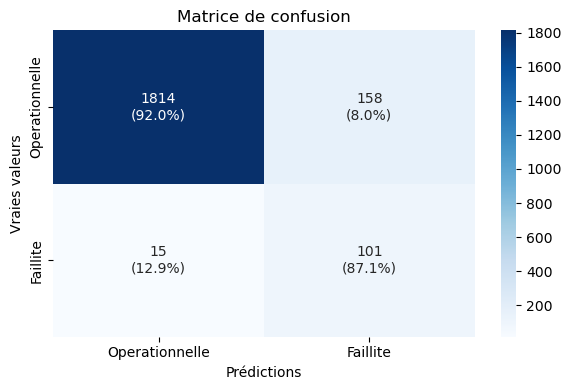

In [324]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve,
    precision_recall_curve
)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(y_test, predictions)

# Calcul des pourcentages ligne par ligne (par classe réelle)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Étiquettes combinées : "valeur (xx%)"
labels = np.array([[f"{val}\n({pct:.1f}%)" for val, pct in zip(row_val, row_pct)]
                   for row_val, row_pct in zip(cm, cm_percent)])

# Affichage avec seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues',
            xticklabels=['Operationnelle', 'Faillite'],
            yticklabels=['Operationnelle', 'Faillite'])

plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.title('Matrice de confusion')
plt.tight_layout()
plt.savefig('cm.png')

plt.show()
plt.close()

###### Rapport de classification

In [325]:
rapport = classification_report(y_test, predictions, output_dict=True)
rapport_df = pd.DataFrame(rapport).transpose()
rapport_df = rapport_df.round(3)

rapport_df_latex= rapport_df.to_latex(index=True)

with open("rapport.tex", "w") as f:
    f.write(rapport_df_latex)

rapport_df 

,precision,recall,f1-score,support
0,0.992,0.920,0.954,1972.000
1,0.390,0.871,0.539,116.000
accuracy,0.917,0.917,0.917,0.917
macro avg,0.691,0.895,0.747,2088.000
weighted avg,0.958,0.917,0.931,2088.000


###### ROC AUC Score

In [326]:
roc_auc = roc_auc_score(y_test, predictions_proba)
print("ROC AUC Score:", round(roc_auc, 3))

ROC AUC Score: 0.931


###### Courbe ROC 

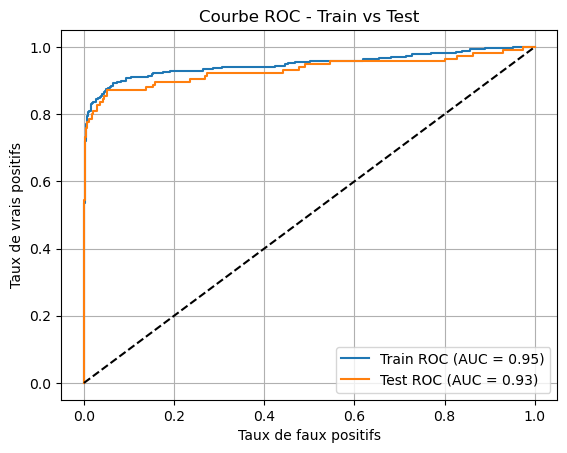

In [327]:
proba_train = resultat1.predict_proba(X_train)[:, 1]
proba_test = resultat1.predict_proba(X_test)[:, 1]

fpr_train, tpr_train, _ = roc_curve(y_train, proba_train)
fpr_test, tpr_test, _ = roc_curve(y_test, proba_test)

auc_train = roc_auc_score(y_train, proba_train)
auc_test = roc_auc_score(y_test, proba_test)

plt.plot(fpr_train, tpr_train, label=f'Train ROC (AUC = {auc_train:.2f})')
plt.plot(fpr_test, tpr_test, label=f'Test ROC (AUC = {auc_test:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC - Train vs Test')
plt.legend()
plt.grid()
plt.savefig('courbe_roc.png')

plt.show()
plt.close()

###### Précision et rappel selon le seuil

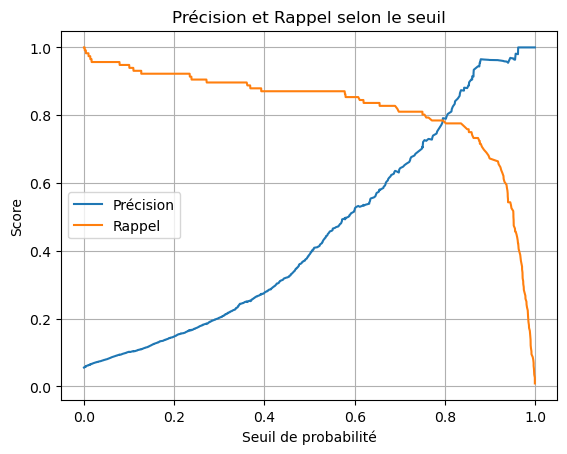

In [328]:
precision, recall, thresholds = precision_recall_curve(y_test, predictions_proba)
plt.plot(thresholds, precision[:-1], label='Précision')
plt.plot(thresholds, recall[:-1], label='Rappel')
plt.xlabel("Seuil de probabilité")
plt.ylabel("Score")
plt.title("Précision et Rappel selon le seuil")
plt.legend()
plt.grid()
plt.savefig('précision_rappel.png') 

plt.show()
plt.close()

### Création de l'application

In [329]:
%%writefile app1.py

import streamlit as st
import joblib
import pandas as pd
import math
import numpy as np
from sklearn.linear_model import LogisticRegression

model = joblib.load('logistic_regression_model1.pkl')

mean_train_age =  16.422058            
mean_train_log_funding  =   14.658503   
mean_train_funding_rounds = 1.973300

std_train_age = 4.821158          
std_train_log_funding = 2.132652       
std_train_funding_rounds =  1.286786    

ocde_dict = {
    'AUS': 'Australie', 'AUT': 'Autriche', 'BEL': 'Belgique', 'CAN': 'Canada', 'CHL': 'Chili', 'COL': 'Colombie',
    'CZE': 'République tchèque', 'DNK': 'Danemark', 'EST': 'Estonie', 'FIN': 'Finlande', 'FRA': 'France',
    'DEU': 'Allemagne', 'GRC': 'Grèce', 'HUN': 'Hongrie', 'ISL': 'Islande', 'IRL': 'Irlande',
    'ITA': 'Italie', 'JPN': 'Japon', 'KOR': 'Corée du Sud', 'LVA': 'Lettonie', 'LTU': 'Lituanie',
    'LUX': 'Luxembourg', 'MEX': 'Mexique', 'NLD': 'Pays-Bas', 'NZL': 'Nouvelle-Zélande',
    'NOR': 'Norvège', 'POL': 'Pologne', 'PRT': 'Portugal', 'SVK': 'Slovaquie', 'ESP': 'Espagne',
    'SWE': 'Suède', 'CHE': 'Suisse', 'TUR': 'Turquie', 'GBR': 'Royaume-Uni', 'USA': 'États-Unis'
}
ocde = sorted(ocde_dict.keys())

tech_dict = {
    "Networking": "Réseautique",
    "Networking_Web_Hosting": "Réseautique & Infrastructure web",
    "Telecommunications": "Télécommunications",
    "Consumer_Electronics": "Appareils éléctroniques",
    "Nanotechnology": "Nanotechnologie",
    "Apps": "Applications mobiles",
    "Technology": "Services technologiques",
    "Biotechnology_Health_Care": "Biotechnologie / Santé",
    "Information_Technology": "Systèmes informatiques",
    "Finance_FinTech": "Technologies financières / FinTech",
    "EdTech_Education": "Technologies éducatives/ EdTech",
    "Entertainment_Games": "Divertissement numérique",
    "Web_Hosting": "Infrastructure Web",
    "Social_Media": "Réseaux sociaux",
    "Analytics": "Analyse de données",
    "Security": "Cybersécurité",
    "Semiconductors": "Semi-conducteurs",
    "Games": "Jeux vidéo",
    "Enterprise_Software": "Logiciels d'entreprise",
    "Hardware___Software": "Matériel & Logiciels",
    "Clean_Technology": "Technologies durables",
    "Curated_Web": "Web organisé",
    "E_Commerce": "E-commerce",
    "Mobile": "Technologies mobiles",
    "Biotechnology": "Biotechnologie",
    "Software": "Logiciels"
}
tech = sorted(tech_dict.keys())


#FONCTION
def predict_faillite(age, log_funding_total_usd, funding_rounds, indicators):
    age_transformed = (age - mean_train_age) / std_train_age
    log_funding_transformed = (log_funding_total_usd - mean_train_log_funding) / std_train_log_funding
    funding_rounds_transformed = (funding_rounds - mean_train_funding_rounds) / std_train_funding_rounds

    input_data = pd.DataFrame({
        'age': [age_transformed],
        'log_funding_total_usd': [log_funding_transformed],
        'funding_rounds': [funding_rounds_transformed],
        **indicators 
    })

    predictions_proba = model.predict_proba(input_data)[:, 1] 

    return predictions_proba[0]


#APPLICATION
st.set_page_config(page_title="Prédiction de faillite", layout="centered")
st.title("Prédiction de la probabilité de faillite d'une entreprise")

st.markdown("Entrez les informations de l'entreprise ci-dessous pour obtenir une estimation du risque de faillite.")
st.markdown("---")

st.header("Caractéristiques de l'entreprise")
col1, col2 = st.columns(2)
with col1:
    age = st.number_input("Âge de l'entreprise (années)", min_value=0.0, max_value=2000.0, step=1.0)
    funding_rounds = st.number_input("Nombre de tours de financement", min_value=0.0, max_value=200.0, step=1.0)

with col2:
    funding_total_usd = st.number_input("Total des financements (USD)", min_value=1.0, step=100000.0)
    if funding_total_usd > 0:
        log_funding_total_usd = math.log(funding_total_usd)
    else:
        st.write("Le total des financements doit être supérieur à 0.")

st.markdown("---")


st.header("Localisation et secteur d’activité")
country_name = st.selectbox("Pays de l'entreprise", sorted(ocde_dict.values()))
country_code = [code for code, name in ocde_dict.items() if name == country_name][0]
category_name = st.selectbox("Secteur d'activité", sorted(tech_dict.values()))
category_list = [key for key, val in tech_dict.items() if val == category_name][0]

#INDICATEURS
indicators = {}
for country in ocde:
    if country == "AUS":
        continue
    indicators[f'country_code_{country}'] = 1 if country_code == country else 0

for category in tech:
    if category == "Analytics":
        continue
    indicators[f'category_list_{category}'] = 1 if category_list == category else 0

st.markdown("---")


if st.button("Prédire la probabilité de faillite"):
    prob_faillite = predict_faillite(age, log_funding_total_usd, funding_rounds, indicators)

    st.metric("Probabilité de faillite", f"{prob_faillite * 100:.2f} %")
    st.progress(min(int(prob_faillite * 100), 100))

    if prob_faillite >= 0.7:
        st.error("⚠️ L'entreprise présente un **fort risque de faillite**. Des mesures préventives sont recommandées.")
    elif prob_faillite >= 0.4:
        st.warning("⚠️ L'entreprise présente un **risque modéré de faillite**. Une surveillance régulière est conseillée.")
    else:
        st.success("✅ L'entreprise semble **stable**. Aucun signal d’alerte identifié à ce stade.")

Overwriting app1.py
